### 테스트용 이미지 다운로드

In [4]:
# 실습용 이미지 다운로드
# !wget https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg
# !ls -lia

In [5]:
# 실습용 이미지 다운로드
# curl을 사용한 다운로드
!curl -O https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 61745  100 61745    0     0  1403k      0 --:--:-- --:--:-- --:--:-- 1470k


In [4]:
pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


### OpenCV 실습
* opencv는 imread(파일경로)로 이미지를 numpy(Channel Last)로 읽어들일 수 있음.
* 유의할 점은 imread() 수행 시 Channel을 RGB가 아닌 BGR 형식으로 읽어 들임.
* 일반적인 RGB 형식으로 변환을 위해서는 cvtColor(numpy, cv2.COLOR_BGR2RGB)로 변환 필요

(579, 1028, 3) <class 'numpy.ndarray'>


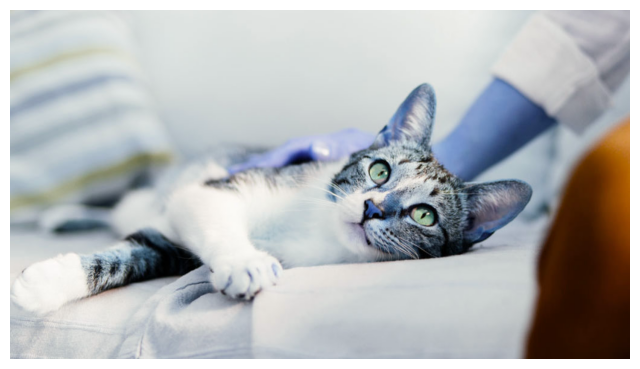

In [6]:
import cv2
import matplotlib.pyplot as plt

#imread()는 BGR Channel 형태로 numpy 반환
image_np = cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg')

def show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')

show_image(image_np)
print(image_np.shape, type(image_np))

(579, 1028, 3) <class 'numpy.ndarray'>


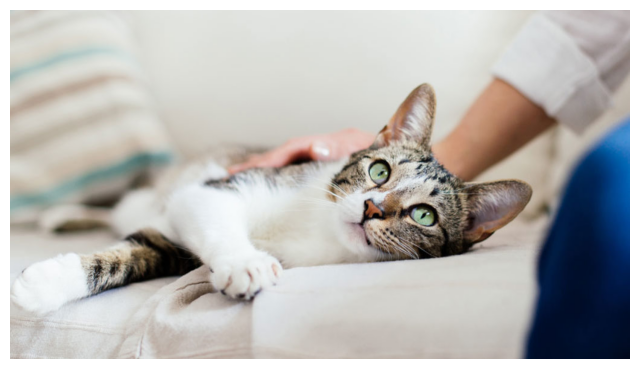

In [7]:
image_np = cv2.cvtColor(cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg'), cv2.COLOR_BGR2RGB)
  
show_image(image_np)

print(image_np.shape, type(image_np))

In [ ]:
# opencv는 이미지를 0~255 사이의 unsigned int 형태로 numpy value 값을 가짐. 
image_np

In [9]:
pip install albumentations

   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ------------- -------------------------- 13.6/39.4 MB 67.9 MB/s eta 0:00:01
   -------------------------- ------------- 25.7/39.4 MB 62.9 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.4 MB 66.1 MB/s eta 0:00:01
   ---------------------------------------- 39.4/39.4 MB 56.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   -------- ------------------------------- 8.4/41.0 MB 38.9 MB/s eta 0:00:01
   ---------------- ----------------------- 17.0/41.0 MB 40.2 MB/s eta 0:00:01
   --------------------------- ------------ 28.6/41.0 MB 44.8 MB/s eta 0:00:01
   -------------------------------------- - 39.6/41.0 MB 46.8 MB/s eta 0:00:01
   ---------------------------------------- 41.0/41.0 MB 41.7 MB/s eta 0:00:00

   ------------- -------------------------- 2/6 [scipy]
   ------------- -------------------------- 2/6 [scipy]
   ------------- --------------------

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



### Albumentations 적용 개요
* Albumentations 역시 transforms와 유사하게 Callable Object 형식으로 적용. 다만 transform 변환된 결과가 Dict형태임.
* Dict 형태로 반환되는 이유는 Object detection등에서 사용되는 bboxes 값등도 함께 반환하기 위함임. 이미지 변환의 경우 'image' key로 추출  
* Albuemntations의 대부분 변환작업은 opencv로 수행되어 numpy로 반환됨.
* pytorch를 위한 Tensor로 변환하는 작업은 맨 마지막에 albumentations.pytorch.ToTensorV2()로 적용함

In [14]:
import albumentations as A

org_img = cv2.cvtColor(cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg'), cv2.COLOR_BGR2RGB)

# Albumentations의 HorizontalFlip 객체 생성 
augmentor = A.HorizontalFlip(p=0.5)
# 생성된 객체에 원본 이미지 변환 수행. 반환은 Dict로
aug_img_dict = augmentor(image=org_img)
# 해당 dict에서 image key로 변환 이미지 추출
aug_img = aug_img_dict['image'] # aug_img = augmentor(image=org_img)['image']

show_image(aug_img)

ModuleNotFoundError: No module named 'albumentations'

In [ ]:
# dict 형태임. image key값으로 변환 image numpy를 가짐.
aug_img_dict

### Normalize와 ToTensorV2 적용 시 유의
* torchvision transforms은 Normalize()가 Tensor만 입력 가능하기 때문에 ToTensor() -> Normalize() 순서로 적용해야 함.
* 하지만 Albumentions는 Normalize()가 입력을 numpy로 받아서 변환함. 그리고 이후에 ToTensorV2()를 적용하는 것이 순서임.
* ToTensorV2()는 0 ~ 255사이의 uint8 numpy값을 입력 받게 되면 tensor로 변환하는 데 0 ~ 1 사이로 정규화 하지 않고 값을 그대로 유지(즉 tensor.uint8 타입) 하지만 Channel Last를 Channel First로 변환함.
* pytorch 모델에 입력될 때는 image가 tensor.float32가 되어야 함. 따라서 Normalize를 적용하여 정규화 적용 및 float32 변환 후 ToTensorV2가 적용되어야 함. 

In [ ]:
augmentor = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
aug_img = augmentor(image=org_img)['image']
print(type(aug_img), aug_img.dtype)
print(aug_img)


In [ ]:
org_img.dtype

In [ ]:
#albumentations내에 pytorch 서브 패키지
from albumentations.pytorch import ToTensorV2

augmentor = ToTensorV2()
aug_img = augmentor(image=org_img)['image']
print(type(aug_img), aug_img.dtype, aug_img.shape)
print(aug_img)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentor = A.Compose([
    A.HorizontalFlip(p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

aug_img = augmentor(image=org_img)['image']
print(type(aug_img), aug_img.dtype, aug_img.shape)
print(aug_img)


In [ ]:
# 여러개의 이미지를 subplots로 시각화
def show_images(images, labels, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])

# augmentor로 입력된 albumentations augmentation을 반복 수행
def repeat_aug(count=4, org_image=None, label=None, augmentor=None):
    image_list = [org_image]
    label_list = ['original']
    
    for i in range(count):
        aug_image = augmentor(image=org_image)['image']
        image_list.append(aug_image)
        label_list.append(label)
              
    show_images(image_list, label_list, ncols=count+1)
    
augmentor = A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT)
#aug_image = augmentor(image=org_image)['image']

repeat_aug(count=4, org_image=org_img, label='Rotate', augmentor=augmentor)

### Augmentation 적용 확률 적용 및 HorizontalFlip과 VerticalFlip
* p 인자를 통해 해당 augmentation을 적용할지, 원본 image를 그대로 유지할 지의 확률 설정. 
* HorizontalFlip은 좌우 반전, VerticalFlip은 상하 반전

In [ ]:
import albumentations as A

augmentor = A.HorizontalFlip(p=0.5)
aug_img = augmentor(image=org_img)['image']

repeat_aug(count=4, org_image=org_img, label='HorizontalFlip', augmentor=augmentor)

In [ ]:
import albumentations as A

augmentor = A.VerticalFlip(p=0.5)
repeat_aug(count=4, org_image=org_img, label='VerticalFlip', augmentor=augmentor)

### Rotation
* 임의 각도로 회전 시키는 Rotate와 임의 90도 각도(90도 간격 회전 90, 180, 270도)로 회전시키는 RandomRotate90


In [ ]:
# 임의 각도로 회전. 최대 -90 ~ 90도. 회전으로 원본 이미지 대비 남는 영역은 검은색으로 대체
augmentor = A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT) #border_mode=cv2.BORDER_REPLICATE
repeat_aug(count=4, org_image=org_img, label='Rotate', augmentor=augmentor)

In [ ]:
augmentor = A.RandomRotate90(p=1)
repeat_aug(count=4, org_image=org_img, label='RandomRotate90', augmentor=augmentor)

### ShiftScaleRotation
* shift와 scale(zoom), rotate를 함께 또는 별개로 적용 가능. shift_limit, scale_limit, rotate_limit값으로 조정. 
* scale만 적용하려면 shift_limit와 rotate_limt를 0으로 설정. 마찬가지로 shift 또는 rotate만 적용 가능

In [ ]:
# shift와 rotate을 0으로 설정하면 scale 적용. scale을 0.5 ~ 1.0으로 설정. 
augmentor = A.ShiftScaleRotate (shift_limit=0, scale_limit=(0.5, 1.0), rotate_limit=0, p=1)
repeat_aug(count=3, org_image=org_img, label='only_scale', augmentor=augmentor)

In [ ]:
# 이동 후 남게 되는 Border를 Near 영역이미지로 복사
augmentor = A.ShiftScaleRotate (shift_limit=(0.2, 0.1), scale_limit=0, 
                                rotate_limit=0, p=1)
repeat_aug(count=3, org_image=org_img, label='only_shift_fillcopy', augmentor=augmentor)

# 이동 후 남게 되는 border를 검은색으로 fill
augmentor = A.ShiftScaleRotate (shift_limit=(0.2, 0.1), scale_limit=0, 
                                rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, p=1)
repeat_aug(count=3, org_image=org_img, label='only_shift_fillblack', augmentor=augmentor)


In [ ]:
# Shift, Scale, Rotate를 한꺼번에 적용. 
augmentor = A.ShiftScaleRotate (p=1)
repeat_aug(count=4, org_image=org_img, label='ShiftScaleRotate', augmentor=augmentor)

### Compose() 를 이용하여 여러 Augmentation를 체인 형태로 연속 적용. 
* compose 자체도 확률을 적용할 수 있음. Default는 p=1

In [ ]:
augmentor = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5)
])

repeat_aug(count=6, org_image=org_img, label='Composite', augmentor=augmentor)

# Compose에 확률 부여
augmentor = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5)
], p=0.5)

repeat_aug(count=6, org_image=org_img, label='Composite', augmentor=augmentor)

### Crop, CenterCrop, RandomCrop, RandomReSizedCrop
* Crop은 입력된 height, width 값 만큼의 원본 이미지의 특정 영역을 잘라낸 후 원본 사이즈로 다시 Resize하지 않음.
* CenterCrop은 원본 이미지의 중심을 기준으로 입력된 height, width 값 만큼의 영역을 Crop 한 뒤 원본 이미지 사이즈로 Resize하지 않음
* RandomCrop은 입력된 height, width 값 만큼의 영역을 Random하게 Crop 한 뒤 원본 이미지 사이즈로 Resize하지 않음
* RandomResizedCrop은 원본 이미지의 Random한 영역을 잘라낸 후, 입력된 height, width값의 사이즈로 Resize함
* RandomResizedCrop은 어떤 영역을 얼마만큼 잘라내는 지는 알수 없으며, 대략적으로 scale과 ratio를 조정하여 적용.
* Crop, CenterCrop, RadomCrop은 적용 후 반드시 원본 이미지 사이즈로 resize 적용 해야 함. 

In [ ]:
# CenterCrop은 원본 이미지의 중심을 기준으로 입력된 height, width 값 만큼의 영역을 Crop 한 뒤 원본 이미지 사이즈로 Resize하지 않음. 
augmentor = A.CenterCrop(height=224, width=224, p=1)
aug_img = augmentor(image=org_img)['image']
print('centercrop image size:', aug_img.shape)
repeat_aug(count=4, org_image=org_img, label='CenterCrop', augmentor=augmentor)

# CenterCrop 후에는 반드시 아래와 같이 resize 해야 함.(augmentation이후 opencv resize()등을 적용해도 무관)
augmentor = A.Compose([
    A.CenterCrop(height=224, width=224, p=1),
    A.Resize(448, 448) # A.Resize(578, 1028)
])
aug_img = augmentor(image=org_img)['image']
print('centercrop and resize image size:', aug_img.shape)
repeat_aug(count=4, org_image=org_img, label='CenterCrop_resize', augmentor=augmentor)

In [ ]:
# RandomCrop은 height, width 값 만큼의 영역을 Random하게 Crop 한 뒤 원본 이미지 사이즈로 Resize하지 않음. 
augmentor = A.RandomCrop(height=224, width=224, p=1)
aug_img = augmentor(image=org_img)['image']
print('randomcrop image size:', aug_img.shape)
repeat_aug(count=4, org_image=org_img, label='random_crop', augmentor=augmentor)

# RandomCrop 후에는 모델 입력 사이즈와 맞게 아래와 같이 resize 해야 함.
augmentor = A.Compose([
    A.RandomCrop(height=224, width=224, p=1),
    A.Resize(448, 448)
])
aug_img = augmentor(image=org_img)['image']
print('centercrop and resize image size:', aug_img.shape)
repeat_aug(count=4, org_image=org_img, label='random_crop', augmentor=augmentor)

In [ ]:
# RandomResizedCrop은 원본 이미지의 Random한 영역을 잘라낸 후, 입력된 height, width값의 사이즈로 Resize함.  
# 어떤 영역을 잘라내는 지는 알수 없으며, 대략적으로 scale과 ratio를 조정하여 적용.  
augmentor = A.RandomResizedCrop(height=224, width=224)
aug_img = augmentor(image=org_img)['image']
print('randomresizedcrop image size:', aug_img.shape)
repeat_aug(count=4, org_image=org_img, label='RandomResizedCrop', augmentor=augmentor)

augmentor = A.Compose([
    A.RandomResizedCrop(height=224, width=224, p=1),
    A.Resize(448, 448)
])
aug_img = augmentor(image=org_img)['image']
print('randomresizedcrop and resize image size:', aug_img.shape)
repeat_aug(count=4, org_image=org_img, label='RandomResizedCrop', augmentor=augmentor)

In [ ]:
# RandomResizedCrop은 원본 이미지의 특정 영역을 잘라낸 후, 입력된 height, width값의 사이즈로 Resize함.  
# scale은 crop할 임의의 영역의 원본 이미지 대비 크기 비율. 
# 원본 height가 100, width가 100이고 scale이 (0.5, 1) 이면 최소 width x height를 50% ~100% 사이를 crop 한 뒤 입력된 height, width값으로 resize함.
# ratio는 crop할 임의의 영역의 가로 세로 비율 
augmentor = A.RandomResizedCrop(height=579, width=1028, scale=(0.5, 0.9), p=1) # height=448, width=448
aug_image = augmentor(image=org_img)['image']

repeat_aug(count=4, org_image=org_img, label='RandomResizedCrop', augmentor=augmentor)

### RandomBrightnessContrast
* 과거 버전은 RandomBrightness와 RandomConstrast가 별도로 존재하였으나 이후 RandomBrightnessContrast로 통합. 
* 밝기와 대비를 함께 조절 
* brightness_limit와 contrast_limit로 조절

In [ ]:
# xxx_limit=(-1, 1)이 (최소, 최대) 범위이고, 0은 변경 적용하지 않음.
augmentor = A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1)
repeat_aug(count=4, org_image=org_img, label='bright_contrast', augmentor=augmentor)

augmentor = A.RandomBrightnessContrast(brightness_limit=(0, 0.2), contrast_limit=(0, 0.2), p=1)
repeat_aug(count=4, org_image=org_img, label='bright_contrast', augmentor=augmentor)

# 밝기는 고정하고 대비만 변경. 
augmentor = A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0, 0.2), p=1)
repeat_aug(count=4, org_image=org_img, label='bright_contrast', augmentor=augmentor)

### HueSaturationValue()
* Hue, Saturation, Value 각각을 특정 범위내에서 임의로 변경
* hue_shift_limit: -20 ~ 20(Default) sat_shift_limit: -30 ~ 30(Default) val_shift_limit: -20 ~ 20(Default)

In [ ]:
import albumentations as A

augmentor = A.HueSaturationValue(p=1)
repeat_aug(count=4, org_image=org_img, label='HueSaturationValue', augmentor=augmentor)

### RGBShift()
* RGB 값 각각을 특정 범위내에서 임의로 변경
* r_shift_limit: -20 ~ 20(Default) g_shift_limit: -20 ~ 20(Default) b_shift_limit: -20 ~ 20(Default)

In [ ]:
augmentor = A.RGBShift(p=1)
repeat_aug(count=4, org_image=org_img, label='RGBShift', augmentor=augmentor)

### ChannelShuffle()
* RGB 채널축을 임의로 변경
* RGB->GBR/GRB/RBG/BGR/BRG 등으로 변경

In [ ]:
augmentor = A.ChannelShuffle(p=1)
repeat_aug(count=4, org_image=org_img, label='RGBShift', augmentor=augmentor)

In [ ]:
augmentor_hsv = A.HueSaturationValue(p=1)
augmentor_rgb = A.RGBShift(p=1)
augmentor_channel = A.ChannelShuffle(p=1)
repeat_aug(count=4, org_image=org_img, label='HSV', augmentor=augmentor_hsv)
repeat_aug(count=4, org_image=org_img, label='RGBShift', augmentor=augmentor_rgb)
repeat_aug(count=4, org_image=org_img, label='ChannelShuffle', augmentor=augmentor_channel)

### ColorJitter
* 밝기(Brightness), 대비(Contrast), 채도(Saturation), Hue(색상)을 임의값으로 변경. 
* brightness, contrast, saturation, hue값으로 조정. 

In [ ]:
#torchvision transforms의 ColorJitter와 유사
augmentor_hsv = A.ColorJitter(
                   brightness=0.5, #밝기를 (1-0.5 ~ 1+0.5) 사이로, 최소값은 0임. [max(0, 1 - brightness), 1 + brightness] 
                   contrast=0.5, #대조를 (1-0.5 ~ 1+0.5) 사이로, 최소값은 0임.  
                   saturation=0.5, #채도를 (1-0.5 ~ 1+0.5) 사이로, 최소값은 0임.
                   hue=0.1, # 색조를 -0.1 ~ 0.1 사이로, 최소는 -0.5, 최대는 0.5
                   p=1)
repeat_aug(count=4, org_image=org_img, label='ColorJitter', augmentor=augmentor_hsv)

#saturation과 hue는 적용하지 않음 
augmentor_hsv = A.ColorJitter(saturation=0, hue=0, p=1) 
repeat_aug(count=4, org_image=org_img, label='ColorJitter', augmentor=augmentor_hsv)

### Gaussian Noise
* Gaussian 분포를 가지는 Noise를 원본 이미지에 추가.

In [ ]:
org_img = cv2.cvtColor(cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg'), cv2.COLOR_BGR2RGB)

In [ ]:
augmentor = A.GaussNoise(var_limit=(100, 200), p=1)
repeat_aug(count=2, org_image=org_img, label='GaussNoise', augmentor=augmentor)

### CoarseDropout
* 임의의 noise hole을 원본 이미지에 추가

In [ ]:
augmentor = A.CoarseDropout(p=1, max_holes=26 )
repeat_aug(count=2, org_image=org_img, label='CoarseDropout', augmentor=augmentor)

### CLAHE(Contrast-limited adaptive histogram equalization)
* 발전된 Histogram equalization(히스토그램 균일화) 기법인 CLAHE를 적용하여 원본 이미지 보다 명암대비가 선명한 이미지 재생

In [ ]:
augmentor_hsv = A.CLAHE(p=1, clip_limit=4)
repeat_aug(count=2, org_image=org_img, label='CLAHE', augmentor=augmentor_hsv)

### Blur, GaussianBlur
* 전체적인 경계선을 흐리게 하거나 Noise를 제거하는 효과(Smoothing). blurring을 위한 filter 를 적용함. 
* 일반적인 Blur는 filter kernel size내의 픽셀값을 평균함. Gaussian Blur는 Gaussian 함수를 통해 kernel 값을 생성
* kernel size는 blur_limit 로 조절되며, kernel size가 클수록 이미지가 더 흐림. 
* kernel size는 홀수가 되어야 함. 따라서 blur_limit에 짝수값은 입력 될 수 없음. 

In [ ]:
augmentor = A.Blur(p=1, blur_limit=(7, 11))
repeat_aug(count=4, org_image=org_img, label='Blur', augmentor=augmentor)

# GaussianBlur의 blur_limit 즉 kernel size는 홀수가 되어야 함. 따라서 blur_limit=(3, 8)과 같이 짝수를 입력하면 안됨. 
augmentor = A.GaussianBlur(p=1, blur_limit=(11, 15))
repeat_aug(count=4, org_image=org_img, label='GaussBlur', augmentor=augmentor)

### OneOf()를 이용하여 여러개의 변환 중 하나의 변환을 선택적으로 적용

In [ ]:
# OneOf() 내에서 VerticalFlip, HorizontalFlip, RandomBrightnessContrast를 각각을 p=1 로 부여했지만 
# 연속해서 Augmentation이 적용 되지 않고, 개별 변환만 적용됨
augmentor = A.OneOf([
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.Rotate(limit=(45, 90), p=1, border_mode=cv2.BORDER_CONSTANT)
    ], p=1)

repeat_aug(count=4, org_image=org_img, label='OneOf', augmentor=augmentor)

In [ ]:
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.OneOf([
        A.CLAHE(p=0.7),
        A.Blur(blur_limit=(11, 15), p=0.3)
    ], p=0.5)
])
repeat_aug(count=4, org_image=org_img, label='OneOf', augmentor=augmentor)
repeat_aug(count=4, org_image=org_img, label='OneOf', augmentor=augmentor)

### Albumentations를 이용하여 augmentation 적용 및 모델 학습 및 성능 평가
* Flowers 데이터를 Dataset으로 생성하고, transform을 albumentations로 적용

#### 데이터 로딩 및 메타 데이터 생성

In [ ]:
!ls /kaggle/input

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os

def create_flowers_meta_df(file_dir):
    paths = [] # 이미지 파일 경로 리스트
    labels = [] # 꽃 종류
    
    # os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
    # kaggle/input/flowers-dataset 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
    # kaggle/input/flowers-dataset 밑으로 하위 디렉토리 존재
    for dirname, _, filenames in os.walk(file_dir):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
                
                # 파일의 절대 경로에 daily, dandelion, roses, sunflowers, tulips에 따라 labels에 값 할당. 
                if 'daisy' in file_path:
                    labels.append('daisy')
                elif 'dandelion' in file_path:
                    labels.append('dandelion')
                elif 'roses' in file_path:
                    labels.append('rose')
                elif 'sunflowers' in file_path:
                    labels.append('sunflowers')
                elif 'tulips' in file_path:
                    labels.append('tulips')
    # DataFrame 메타 데이터 생성. 
    data_df = pd.DataFrame({'path':paths, 
                            'label':labels})
    # Target값  변환
    label_mapping = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflowers': 3, 'tulips': 4}
    data_df['target'] = data_df['label'].map(label_mapping)

    return data_df

data_df = create_flowers_meta_df('/kaggle/input') # /kaggle/input/flowers-dataset

# 전체 데이터 세트에서 학습(전체의 70%)과 테스트용(전체의 30%) 메타 정보 DataFrame 생성.
train_df, test_df = train_test_split(data_df, test_size=0.3, stratify=data_df['target'], random_state=2025)
# 기존 학습 DataFrame을 다시 학습과 검증 DataFrame으로 분할. 80%가 학습, 20%가 검증
tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['target'], random_state=2025)

print(data_df.shape, train_df.shape, tr_df.shape, val_df.shape, test_df.shape)

#### albumentations를 transform으로 하는 Custom Dataset 생성

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2

class FlowerDataset(Dataset):
    # 이미지 파일리스트, 타겟 파일리스트, transforms 등 이미지와 타겟 데이터 가공에 필요한 인자들을 입력 받음
    def __init__(self, image_paths, targets=None, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        # albumentations 변환 객체를 self.transform으로 할당. 
        self.transform = transform
    
    # 전체 건수를 반환
    def __len__(self):
        return len(self.image_paths)
        
    # idx로 지정된 하나의 image, label을 tensor 형태로 반환
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
       # opencv로 이미지 파일 로딩
        image_np = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)#.astype(np.float32)
        # albumentations 변환 객체에 numpy image 배열 입력하고 변환된(ToTensorV2 적용된) image tensor 반환
        image = self.transform(image=image_np)['image']

        if self.targets is not None:
            # 개별 target값을 tensor로 변환.
            target = torch.tensor(self.targets[idx])
            return image, target
        # 테스트 데이터의 경우 targets가 입력 되지 않을 수 있으므로 이를 대비. 
        else:
            return image

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406] # ImageNet 데이터세트의 이미지 채널별 평균값
IMG_STD = [0.229, 0.224, 0.225] # ImageNet 데이터세트의 이미지 채널별 표준편차값

#albumentations transform(augmentor 생성)
tr_transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
#학습과 검증용 DataLoader 생성 함수
def create_tr_val_loader(tr_df, val_df, tr_transform, val_transform):
    tr_dataset = FlowerDataset(image_paths=tr_df['path'].to_list(), 
                            targets=tr_df['target'].to_list(), transform=tr_transform)
    val_dataset = FlowerDataset(image_paths=val_df['path'].to_list(), 
                            targets=val_df['target'].to_list(), transform=val_transform)
    
    tr_loader = DataLoader(tr_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    return tr_loader, val_loader

#학습과 검증용 DataLoader 생성
tr_loader, val_loader = create_tr_val_loader(tr_df=tr_df, val_df=val_df,
                                             tr_transform=tr_transform, val_transform=val_transform)

images, labels = next(iter(tr_loader))
print(images.shape, labels.shape)

#### 모델 생성 및 Trainer 클래스로 학습 수행

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

def create_resnet_model(model_name, num_classes=10, weights='DEFAULT'):
    model = None
    if model_name == 'resnet50':
        model = models.resnet50(weights=weights)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=weights)
    
    num_in_features = model.fc.in_features
    model.fc = nn.Linear(in_features=num_in_features, out_features=num_classes)

    return model
    
resnet_model = create_resnet_model('resnet50', num_classes=5, weights='DEFAULT') #resnet50, resnet101

In [ ]:
# /kaggle/working/modular/v1 디렉토리에 utils.py 파일 다운로드
!rm -rf ./modular/v1
!mkdir -p ./modular/v1
!wget -O ./modular/v1/utils.py https://raw.githubusercontent.com/chulminkw/CNN_PG_Torch/main/modular/v1/utils.py?raw=true
!ls ./modular/v1

import sys

# 반드시 system path를 아래와 같이 잡아줘야 함. 
sys.path.append('/kaggle/working')

#아래가 수행되는지 반드시 확인
from modular.v1.utils import Trainer, ModelCheckpoint, EarlyStopping, Predictor

In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# 5개의 꽃 종류
NUM_CLASSES = 5

def train_flowers_with_aug(tr_df, val_df, tr_transform, val_transform, epochs=20):
    tr_loader, val_loader = create_tr_val_loader(tr_df=tr_df, val_df=val_df, 
                                                 tr_transform=tr_transform, val_transform=val_transform)
    model = create_resnet_model('resnet50', num_classes=NUM_CLASSES, weights='DEFAULT')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    # 여러 augmentation 비교를 위해서 고정된 패턴의 학습율 적용을 위해 StepLR 선택.
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    # callbacks는 None
    trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer,
                      train_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, callbacks=None, 
                      device=device)
    # 학습 및 평가.
    history = trainer.fit(epochs)
    #학습된 trainer와 history 반환. 
    return trainer, history

#### 다양한 Augmentation 적용하여 학습 및 성능 평가 - 01

In [ ]:
IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406] # ImageNet 데이터세트의 이미지 채널별 평균값
IMG_STD = [0.229, 0.224, 0.225] # ImageNet 데이터세트의 이미지 채널별 표준편차값

#albumentations transform(augmentor 생성)
tr_transform_aug_01 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.2, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.2),
    A.ColorJitter(p=0.2),
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

trainer, history = train_flowers_with_aug(tr_df, val_df, 
                                          tr_transform=tr_transform_aug_01, val_transform=val_transform,
                                          epochs=30)

#### 테스트 데이터로 성능 평가

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406] # ImageNet 데이터세트의 이미지 채널별 평균값
IMG_STD = [0.229, 0.224, 0.225] # ImageNet 데이터세트의 이미지 채널별 표준편차값

#albumentations transform(augmentor 생성)
test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

test_image_paths = test_df['path'].to_list()
test_targets = test_df['target'].to_list()

test_dataset = FlowerDataset(image_paths=test_image_paths, 
                            targets=test_targets, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

trained_model = trainer.get_trained_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

#### 다양한 Augmentation 적용하여 학습 및 성능 평가 - 02

In [ ]:
#albumentations transform(augmentor 생성)
tr_transform_aug_02 = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1), # 원본 이미지가 설정된 crop size보다 작을 경우 오류 발생하므로 Resize를 먼저 적용. 
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.CenterCrop(200, 200, p=0.4), # 원본 이미지가 설정된 crop size보다 작을 경우 오류 발생. 
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, p=1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

trainer, history = train_flowers_with_aug(tr_df, val_df, 
                                          tr_transform=tr_transform_aug_02, val_transform=val_transform,
                                          epochs=30)

In [ ]:
trained_model = trainer.get_trained_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')